In [5]:
# importing all our packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [6]:
# set plot options

plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = '#00bfbf'

In [7]:
# Lets set the scene - working for a social media company and the company is growing 
# concerned around the amount of fake news circulating on it's platform
# They've assigned you, as a data scientist, to investigate how quick news can be recognized and create a method of identifying it

# First by Exploring and cleaning the data
# then working to classify Fake VS Factual news stories 
# we will also create plots of our outputs and communicate our findings to stakeholders

In [8]:
# start by importing our dataset and have a look at what it looks like with the head() method

data = pd.read_csv('fake_news_data.csv')

data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [9]:
# we'll also call info() method to see if there is any missing data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

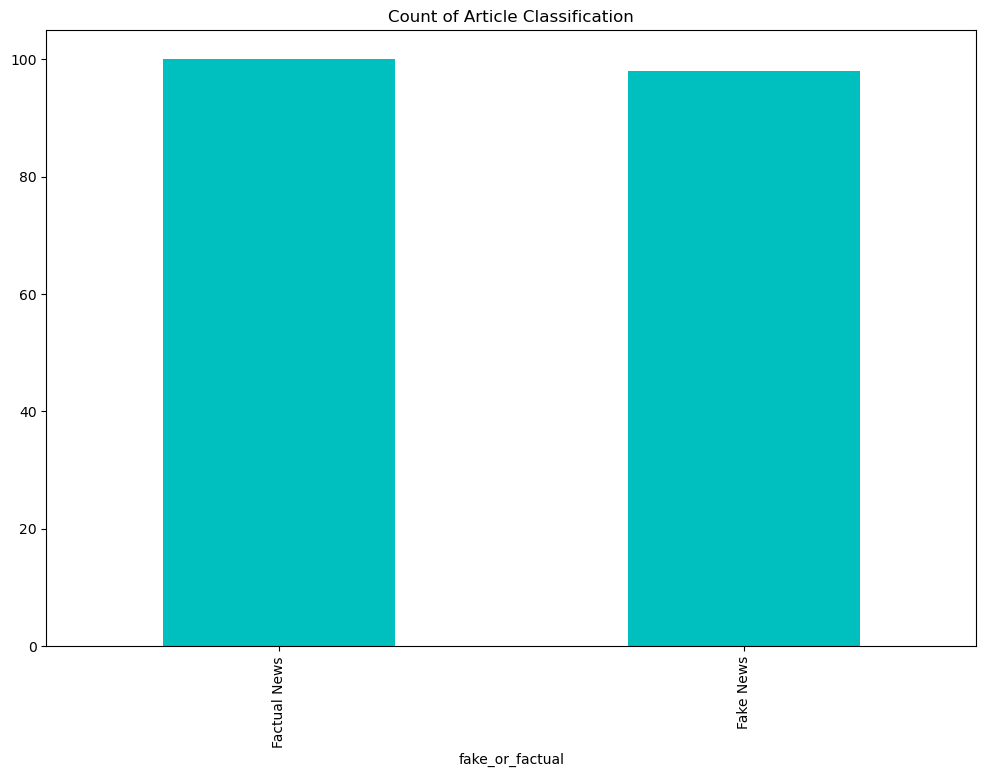

In [10]:
# Before we move on to any kind of comparison between the fake and factual news articles
# we need to make sure we have an appropriate number of rows in each group


data['fake_or_factual'].value_counts().plot(kind = 'bar', color = default_plot_colour)
plt.title('Count of Article Classification')

# we can see an equal number of fake and factual articles which is perfect to go through with our analysis
# if we did have a significant difference in the numbers of rows we would need to take additional steps to make this a balanced dataset

### POS Tagging

In [11]:
# we'll start by initializing our spacy model

nlp = spacy.load('en_core_web_sm')

In [12]:
# One of our task is to determine the difference between fake and factual news
# we want to split out the dataset into fake news and factual news and then we can compare 
# the POS tags that occur between each dataset

# we'll filter the fake or factual column into 2 variables

fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [13]:
# from this we can create our 2 seperate spacy documents
# because we aare working over a DataFrame we'll want to use nlp.Pipe over our fake news text column and make it a list
# same with factual news

fake_spacydocs = list(nlp.pipe(fake_news['text']))

fact_spacydocs = list(nlp.pipe(fact_news['text']))


In [14]:
# we'll then create a function to extract each of the tags of each of the documents in our data
# we'll return the text, ent_type and pos tag for each item in the document

def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]


In [15]:
# starting with fake news lets create an empty list

fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

# we then want to iterate through each of the documents and through each of the rows in our dataframe and pull out the rekevant tags

for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc) # we'll use the extract token tags function we created with the argument we provide being the doc
    tags = pd.DataFrame(tags) # we then convert these tags into a dataframe
    tags.columns = columns # with the column names as the column variable we specified earlier
    fake_tagsdf.append(tags) # we then append these tags into our empty list

# Once we have gone through each of the documents and we've populated our fake_tagsdf list
# we'll then use pd.concat to get it into the right function and assign it back to fake_tagsdf

fake_tagsdf = pd.concat(fake_tagsdf)

In [16]:
# we then do the exact same for our factual dataset

fact_tagsdf = []

for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

fact_tagsdf = pd.concat(fact_tagsdf)

In [17]:
# lets see what this looks like so far - aall tokens are tagged
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [18]:
# Token frequency count - because we havent cleaned our dataset, this is mostly punctuation and stopwords

pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False)

pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [19]:
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False)

pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [20]:
# looking at the frequency of POS Tags occur 

pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending = False).head(10)


pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [21]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending = False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [22]:
# for the sake of this example we'll look at nouns frequency, just replace nouns with other PoS for results you want
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
8011,year,NOUN,44
3138,campaign,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [23]:
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
2497,campaign,NOUN,42


### Extracting Name Entities

In [24]:
# Start by pulling out the top entities from our fake news dataset
# as well as the factual dataset


top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False)

top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False)

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

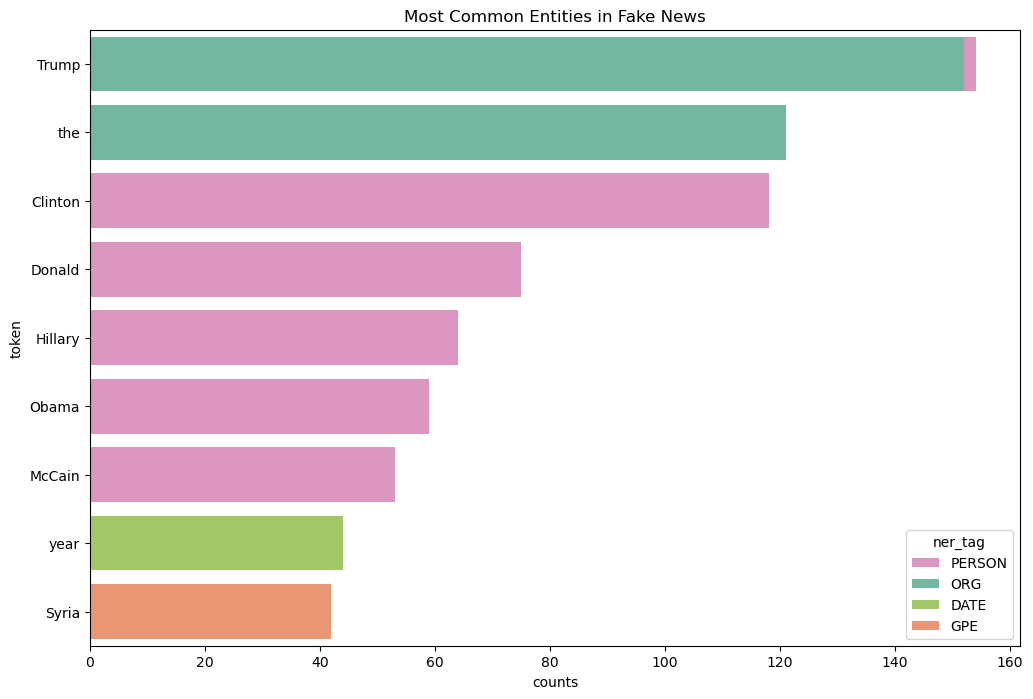

In [25]:
# Create some plot of the named entities that have been pulled out to be used in presentations
# we make a colour palette to make sure both plots are in the same colours

ner_palette = {
    'ORG' : sns.color_palette('Set2').as_hex()[0],
    'GPE' : sns.color_palette('Set2').as_hex()[1],
    'NORP' : sns.color_palette('Set2').as_hex()[2],
    'PERSON' : sns.color_palette('Set2').as_hex()[3],
    'DATE' : sns.color_palette('Set2').as_hex()[4],
    'Cardinal' : sns.color_palette('Set2').as_hex()[5],
    'PERCENT' : sns.color_palette('Set2').as_hex()[6]  
}


sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[:10],
    orient = 'h',
    dodge = False
).set(title = 'Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

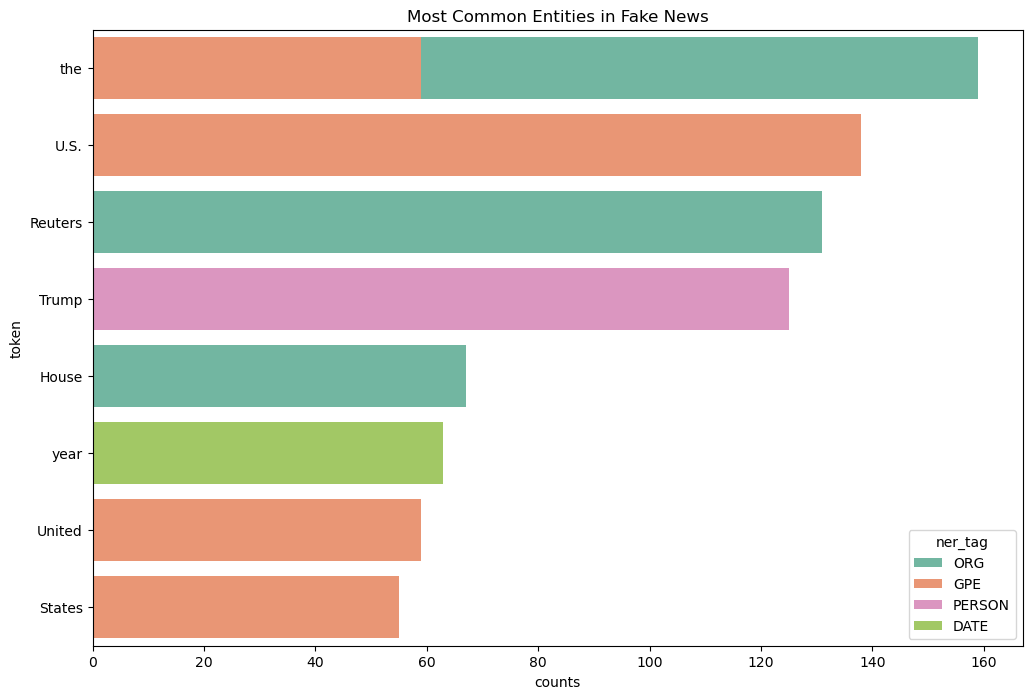

In [26]:

sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[:10],
    orient = 'h',
    dodge = False
).set(title = 'Most Common Entities in Fake News')

### Text Preprocessing

In [27]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [28]:
# we'll clean up just our text column - some have a location tag at the start of the text and a hyphen, which we will be cleaning up
# as it might mess up our analysis a little bit - we will remove everything before that first hyphen using a Regex

# we'll use the re.sub() function to go over all the rows in our dataset

data['text_clean'] = data.apply(lambda x: re.sub(r'^[^-]*-\s', '', x['text']), axis = 1)

In [29]:
# do the usual preprocessing steps
# Lowercase,  

data['text_clean'] = data['text_clean'].str.lower()

# remove punctuation,

data['text_clean'] = data.apply(lambda x: re.sub(r'([^\w\s])', '', x['text_clean']), axis = 1)



In [30]:
# Removing stopwords

en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [31]:
# happy with our stopwords list, we now remove the stopwords from our text

data['text_clean'] = data['text_clean'].apply(lambda x: ' ' .join([word for word in x.split() if word not in (en_stopwords)]))

In [32]:
# jumping in to tokenize the text

data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis = 1)

In [33]:
# And finally Lemmatizing

lemmatizer = WordNetLemmatizer()

data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [34]:
# lets create a list of our cleaned tokens so we can look at N-Grams

tokens_clean = sum(data['text_clean'], [], )

In [35]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams[:10])

bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams[:10])

trigrams = (pd.Series(nltk.ngrams(tokens_clean, 3)).value_counts()).reset_index()[:10]
print(trigrams[:10])

           index  count
0       (trump,)    580
1        (said,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137
                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8  (trump, administration)     26
9         (official, said)     26
                           index  count
0     (president, donald, trump)     46
1     (president, barack, obama)     14
2              (new, york, time)     11
3         (u, president, donald)     10
4           (food, stamp, fraud)     10
5       (white, house, official)     10
6         (fbi, director, james)      8
7       (director, james, comey)      8
8 

C:\Users\Behemoth Admin\AppData\Local\Temp\ipykernel_2748\2290584598.py:2: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


[Text(0.5, 1.0, 'Most Common Unigrams after Preprocessing')]

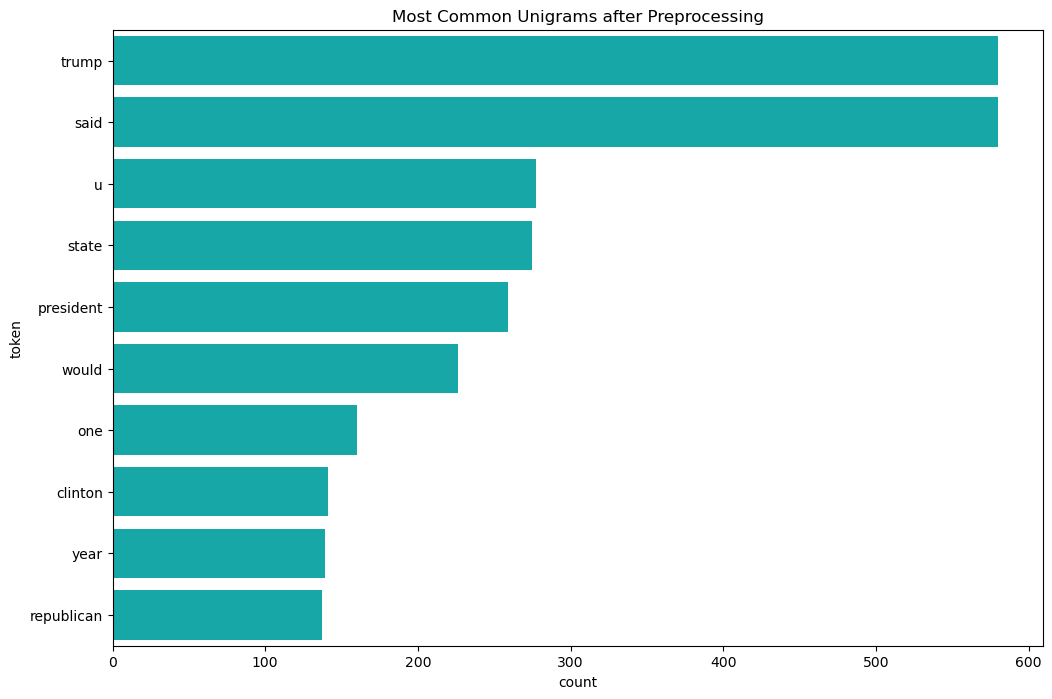

In [36]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])
sns.barplot(
    x = 'count',
    y = 'token',
    data = unigrams,
    orient = 'h',
    palette = [default_plot_colour],
    hue = 'token', 
    legend = False).set(title = "Most Common Unigrams after Preprocessing")

### Sentiment Analysis

In [37]:
# We are going to try answer the question: 'Does Sentiment Differ between the different news types'

In [38]:
# begin with initializing the analyzer

vader_sentiment = SentimentIntensityAnalyzer()

In [39]:
# we want to create a new column to show the sentiment score

data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [40]:
# printing out the data we can now see our scores

data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [41]:
# we now want to  create bins and sentiment labels for our scores

bins = [-1, -0.1, 0.1, 1]

names = ['negative', 'neutral', 'positive'] 

# we then create our vader sentiment label column and use the pd.cut() function
# this function takes our score column chops it up by the different bins and gives the labels that we specified in names above

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels = names)

# run data.head to check the working

data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [42]:
# let's now see if we can use this to answer the question we had: " does sentiment differe between the different news types? "

<Axes: xlabel='vader_sentiment_label'>

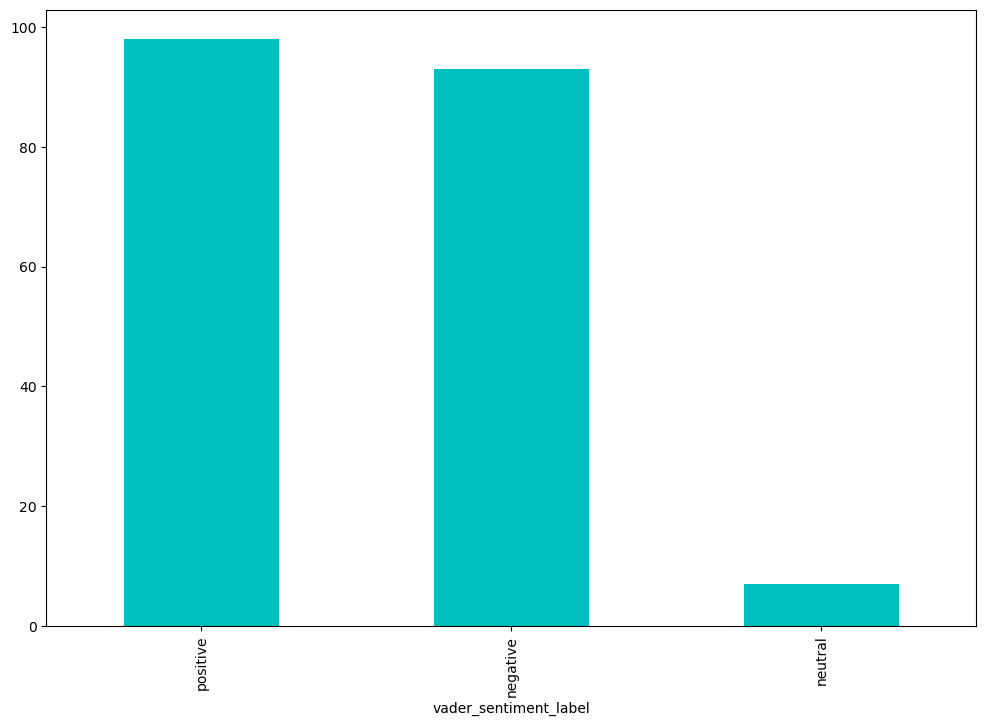

In [43]:
data['vader_sentiment_label'].value_counts().plot.bar(color = default_plot_colour)
# running this we can see the values are fairly even between the sentiment types with a handful of neutral ones

C:\Users\Behemoth Admin\AppData\Local\Temp\ipykernel_2748\1593377029.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

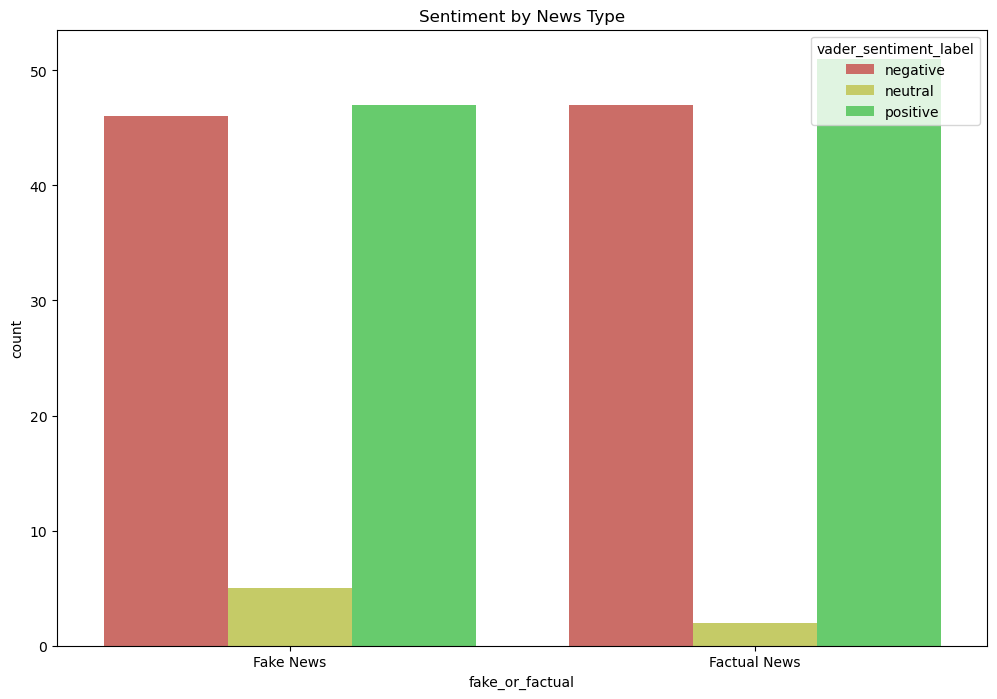

In [44]:
# lets now compare between fake and factual news if their is a difference in Sentiment

sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette('hls'),
    data = data
).set(title = "Sentiment by News Type")


# we can see with Fake News the data is even between positive and negative with some neutrals
# with Factual the data is relatively even however it is skewed more to positive

### Topic Modelling

In [45]:
# We are trying to see what topics appear in our Fake News
# we are interested in seeing what topics come up that might help us identify a fake news article

# for this we will use topic modelling and we'll start with LDA - Latent Dirichlet Allocation


In [46]:
# The first step for us will be to vectorize our Text

fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop = True)

In [47]:
# we then want to create our dictionary

dictionary_fake = corpora.Dictionary(fake_news_text)

In [48]:
# Finally creating our bag of words

doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [49]:
# Jumping striaght in to generate coherence scores to determine the optimal number of topics
# So we create an empty list for coherence values and an empty list for our models
# we'll also set our min and max topics

coherence_values = []
model_list = []
min_topics = 2
max_topics = 11

# we'll now create a for loop to run over each iteration of our model
# This will leave us a list of all our models and a list of the coherence values

for num_topics_i in range(min_topics, max_topics + 1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics = num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model = model, texts = fake_news_text, dictionary = dictionary_fake, coherence = 'c_v')
    coherence_values.append(coherence_model.get_coherence())



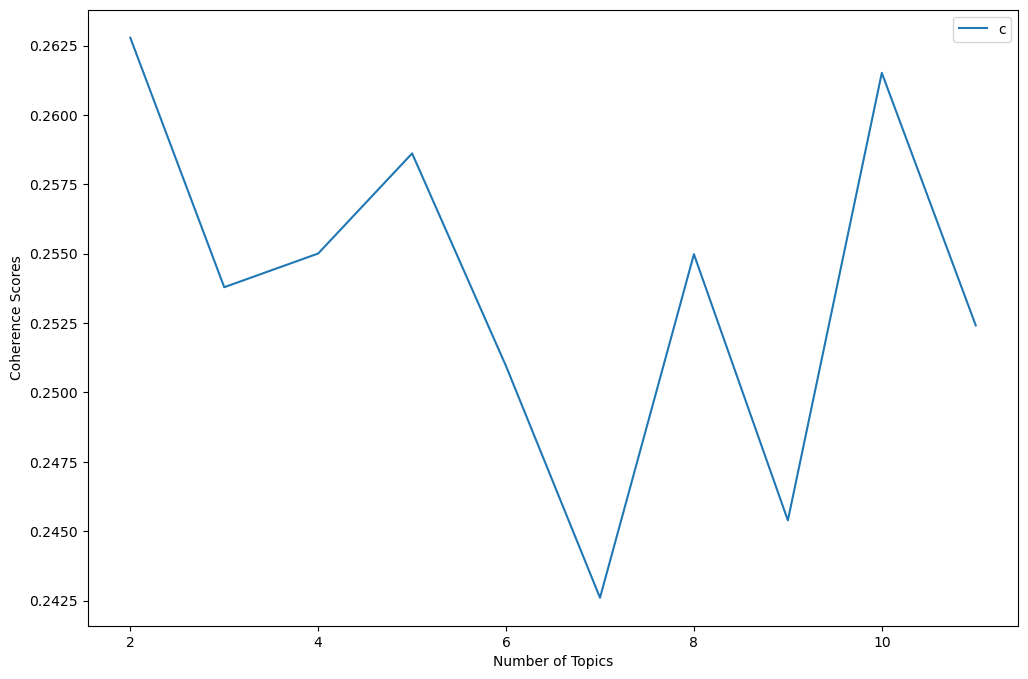

In [50]:
# We'll plot to find the best number of topics to run through our model

plt.plot(range(min_topics, max_topics + 1), coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.legend(('coherence_values'), loc = 'best')
plt.show()

In [55]:
# Looks like 4 is the best value for us *** side note my graph changes as you rerun the entire code adjust accordingly
# we'll also create our LDA model, with out doc term fake, our dictionary fake and the number of topics we want to use

num_topics_lda = 5
lda_model = gensim.models.LdaModel(corpus = doc_term_fake, id2word = dictionary_fake, num_topics = num_topics_lda)

# print_topics to print out the words that most commonly occur with each topic - in this example 10

lda_model.print_topics(num_topics = num_topics_lda, num_words = 10)

[(0,
  '0.006*"president" + 0.006*"trump" + 0.004*"would" + 0.004*"state" + 0.004*"mccain" + 0.004*"said" + 0.004*"u" + 0.004*"time" + 0.003*"clinton" + 0.003*"one"'),
 (1,
  '0.014*"trump" + 0.006*"said" + 0.005*"clinton" + 0.004*"donald" + 0.004*"president" + 0.004*"u" + 0.004*"would" + 0.004*"state" + 0.003*"time" + 0.003*"one"'),
 (2,
  '0.007*"trump" + 0.005*"president" + 0.004*"u" + 0.004*"clinton" + 0.004*"said" + 0.003*"one" + 0.003*"state" + 0.003*"would" + 0.003*"year" + 0.003*"people"'),
 (3,
  '0.013*"trump" + 0.005*"clinton" + 0.004*"state" + 0.004*"one" + 0.004*"president" + 0.004*"time" + 0.004*"woman" + 0.003*"republican" + 0.003*"would" + 0.003*"said"'),
 (4,
  '0.013*"trump" + 0.006*"said" + 0.004*"state" + 0.004*"people" + 0.004*"million" + 0.003*"donald" + 0.003*"would" + 0.003*"president" + 0.003*"food" + 0.003*"republican"')]

In [52]:
# Alot of the topics came out very similair, lets try a different method
# onje of the first changes we can make is using the Tf IDF method as opposed to the bag of words model
# Next we'll also wswap to LSA - Latent Senetiment Anlysis instead of LDA 

# we'll need to create a couple of different functions
# first we'll need a function to create our tfidf corpus

def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize = True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

# we then want to create a function to get the coherence scores to get the optimal number of topics

def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics + 1):
        model = LsiModel(corpus, num_topics = num_topics_i, id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts = text, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherence_model.get_coherence())
    plt.plot(range(min_topics, max_topics + 1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend(('Coherence_values'), loc = 'best')
    plt.show()


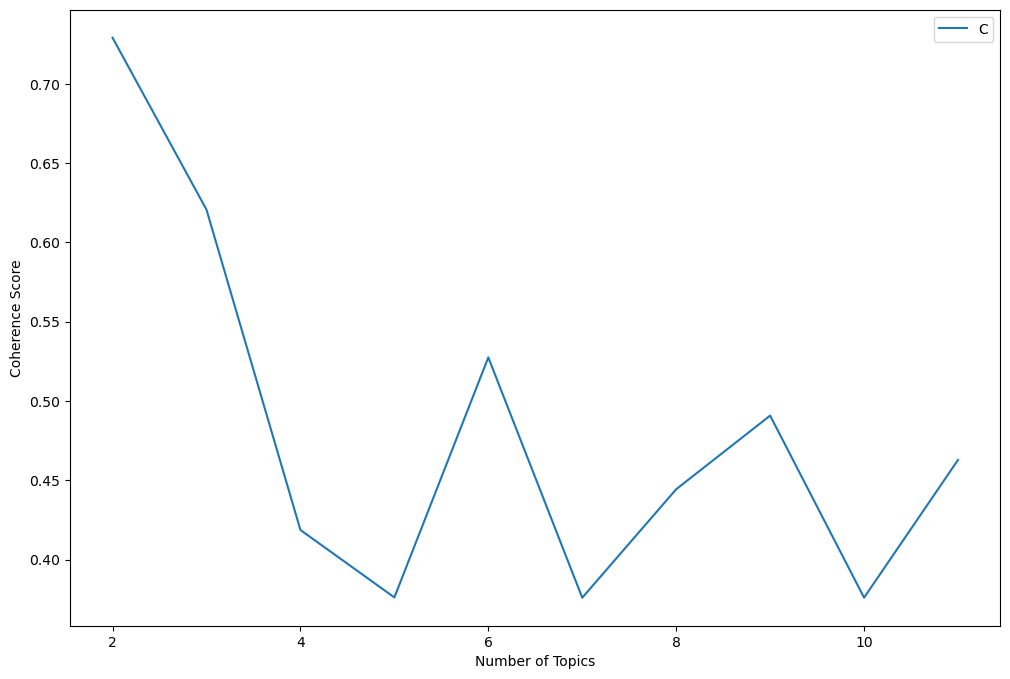

In [53]:
# Now that we have created our functions lets create our TF IDF representation of the text

corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

# from here we can get our coherence scores using the function we just created

get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics = 2, max_topics = 11)

In [57]:
# we can see optimal number is 2, however it is low so I'll use 7 for this*** again graph will change if re-running the entire code again

lsa_model = LsiModel(corpus_tfidf_fake, id2word = dictionary_fake, num_topics = 7)

lsa_model.print_topics()

# we can see a more varied lsit of topics here - more interesting to look around

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '0.325*"boiler" + 0.284*"acr" + 0.244*"room" + 0.240*"pm" + 0.186*"broadcast" + 0.180*"radio" + 0.142*"animal" + 0.142*"tune" + 0.134*"jay" + 0.132*"episode"'),
 (2,
  '-0.623*"flynn" + -0.182*"immunity" + -0.122*"nana" + -0.116*"mr" + -0.110*"30" + -0.108*"march" + -0.102*"russian" + -0.100*"source" + 0.095*"school" + -0.092*"adviser"'),
 (3,
  '0.217*"clinton" + -0.186*"school" + -0.176*"student" + 0.141*"hillary" + -0.121*"county" + -0.121*"flynn" + 0.110*"sander" + 0.098*"debate" + 0.097*"woman" + 0.091*"nominee"'),
 (4,
  '0.200*"email" + -0.194*"trump" + 0.168*"dnc" + -0.142*"flynn" + 0.126*"clinton" + -0.112*"cruz" + 0.111*"department" + 0.110*"rich" + 0.102*"wikileaks" + 0.099*"sander"'),
 (5,
  '-0.276*"student" + -0.160*"conference" + -0.160*"school" + -0.137*"trump" + 0.125*"mccain" + 

### Creating our Classification Model

In [58]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [59]:
x = [','.join(map(str, l)) for l in data['text_clean']]
y = data['fake_or_factual']

In [62]:
countvec = CountVectorizer()

countvec_fit = countvec.fit_transform(x)

In [64]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [65]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, y, test_size = 0.3)

In [66]:
lr = LogisticRegression(random_state = 0).fit(x_train, y_train)

In [67]:
y_pred_lr = lr.predict(x_test)

In [68]:
accuracy_score(y_pred_lr, y_test)

0.8833333333333333

In [70]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.84      0.97      0.90        32
   Fake News       0.96      0.79      0.86        28

    accuracy                           0.88        60
   macro avg       0.90      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



In [71]:
svm = SGDClassifier().fit(x_train, y_train)

In [72]:
y_pred_svm = svm.predict(x_test)

In [73]:
accuracy_score(y_pred_svm, y_test)

0.85

In [74]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.81      0.94      0.87        32
   Fake News       0.91      0.75      0.82        28

    accuracy                           0.85        60
   macro avg       0.86      0.84      0.85        60
weighted avg       0.86      0.85      0.85        60

